In [0]:
%%capture
pip install arcgis

In [0]:
import os
from google.colab import drive
from pathlib import Path
import gdal 
import glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from arcgis.gis import GIS
from arcgis.geocoding import reverse_geocode
import cv2
import pylab

gis = GIS()

In [0]:
drive.mount('/content/drive', force_remount=True)
%cd drive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [0]:
## all directories
dirRoot = 'damaged_structures_detector'
dirInput = 'damaged_structures_detector/from_user_input_image'
dirImages = os.path.join(dirRoot,'temp','images')

In [0]:
inputImagename = os.listdir(dirInput)[0]
###listen for change
fileSize = Path(os.path.join(dirInput, inputImagename)).stat().st_size/1e6
print('Input Image name:\t {image}'.format(image = inputImagename))
print('Input Image size:\t {size:.0f} Mb'.format(size = fileSize))
#######################
image = gdal.Open(os.path.join(dirInput, inputImagename))
latlon = pd.read_csv(os.path.join('damaged_structures_detector/data','buildingsCentroids.csv'))


Input Image name:	 input_image.tif
Input Image size:	 271 Mb


Master plan:
1. Overlay image with center of segmented buildings
2. Calculate histogram of building sizes in the image
3. crop square images based on 75th percentile building size at the center of building locations. Name the image as locations (lon_lat.jpg)
4. forward prop. Import prediction function, best model, etc. 
5. make a table of image name, and predictions
6. convert table to csv in the form GEE expects
7. upload csv to my GEE. and input image
8. In GEE visualize image, join the locations with building footprints and color the buildings. visualize. 

In [0]:
images = os.listdir(dirImages)
print('Number of images to classify:\t {number:0d}'.format(number = len(images)))

Number of images to classify:	 1725


In [0]:
# making a dummy table until marios finishes forward prop work

preds = pd.DataFrame({'image':images, 'damage':np.random.choice([0,1],size = len(images))})
##damage = 1 means destroyed. 0 means not destroyed.
SCALE=1e7
preds['longitude'] = [np.float(x.split('_')[0])/SCALE for x in preds['image']]
preds['latitude'] =  [np.float(x.replace('.jpg','').split('_')[1])/SCALE for x in preds['image']]
## Print sample of predictions
preds.index.name = 'index'
print(preds.head())
preds.to_csv(os.path.join(dirRoot, 'preds.csv'))

                           image  damage   longitude   latitude
index                                                          
0      -1216103393_397555717.jpg       0 -121.610339  39.755572
1      -1216212245_397530785.jpg       1 -121.621224  39.753079
2      -1216172280_397563225.jpg       0 -121.617228  39.756323
3      -1216067300_397422240.jpg       0 -121.606730  39.742224
4      -1216184766_397424148.jpg       0 -121.618477  39.742415


Plot Channel Histograms for image datasets

Number of images:  11380


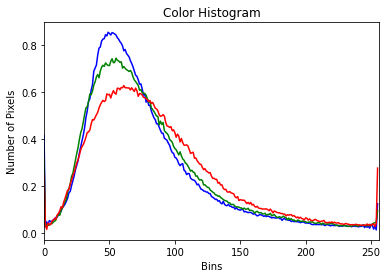

In [0]:
hist_b = np.zeros((256,1), dtype=float)
hist_r = np.zeros((256,1), dtype=float)
hist_g = np.zeros((256,1), dtype=float)
num_img = 0
path = "damaged_structures_detector/temp/images"

for image in os.listdir(path):
    try:      
      img = cv2.imread(os.path.join(path, image))    # Load the image 
      channels = cv2.split(img)       # Set the image channels
     
      hist_b += cv2.calcHist(channels[0], [0], None, [256], [0, 256])
      hist_g += cv2.calcHist(channels[1], [0], None, [256], [0, 256])
      hist_r += cv2.calcHist(channels[2], [0], None, [256], [0, 256])
      num_img += 1

    except:
      pass


hist_b /= num_img
hist_g /= num_img
hist_r /= num_img

print('Number of images: ', num_img)

plt.figure()    
plt.title("Color Histogram")
plt.xlabel("Bins")
plt.ylabel("Number of Pixels")
plt.plot(hist_b, color = 'b')      # Plot the histogram
plt.plot(hist_g, color = 'g')
plt.plot(hist_r, color = 'r')
plt.xlim([0, 256])
plt.savefig('damaged_structures_detector/temp/kappa.png', format = 'png', dpi = 1200)
plt.show()

Transform new data to match Paradise

In [0]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """
    
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        def remove_prefix(str, prefix):
         return str.lstrip(prefix)
        
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        path = remove_prefix(path, 'damaged_structures_detector/temp2/images')
        
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [0]:
paradise_mean = torch.tensor([0.3723, 0.3529, 0.3520])
paradise_std = torch.tensor([0.1647, 0.1612, 0.1580])
carr_mean = torch.tensor([0.6223, 0.6724, 0.7026])
carr_std = torch.tensor([0.1532, 0.1463, 0.1305])

data_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=paradise_mean,
                             std=paradise_std)
    ])

data_transform_carr = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=carr_mean,
                             std=carr_std)
    ])

BATCH_SIZE = 128
FOLDERNAME = 'damaged_structures_detector/temp'
FOLDERNAME_carr = 'damaged_structures_detector/temp2'

paradise_dataset = ImageFolderWithPaths(FOLDERNAME, transform = data_transform)
loader_paradise = DataLoader(paradise_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 8)

carr_dataset = ImageFolderWithPaths(FOLDERNAME_carr, transform = data_transform_carr)
loader_carr = DataLoader(carr_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 8)

Calculate mean and std of dataloader

In [0]:
mean = 0.
std = 0.
nb_samples = 0.
for data, labels, paths in loader_carr:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [0]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cpu


In [0]:
%%capture
MODEL_PATH = "damaged_structures_detector/checkpoints/best_model.pth"
model = torch.load(MODEL_PATH, map_location=device)
model.to(device)
model.eval()

In [0]:
output_df = pd.DataFrame({'image': [], 'damage': [], 'longitude': [], 'latitude': [], 'address': [], 'GEOID': []})

SCALE=1e7
no_add  = 0
yes_add = 0

# iterate over data
for inputs, labels, paths in loader_carr:
    inputs = inputs.to(device)

    with torch.no_grad():
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

    for i in range(len(paths)):
      img_loc   = paths[i]
      pred_loc  = int(preds[i].data)
      log_loc   = np.float(paths[i].split('_')[0])/SCALE
      lat_loc   = np.float(paths[i].replace('.jpg','').split('_')[1])/SCALE
      
      try:
        add_loc = reverse_geocode([log_loc, lat_loc])['address']['LongLabel']
      except:
        add_loc = ''
      geo_loc   = 0
      
      if len(add_loc) < 30:
        no_add  += 1
      else:
        yes_add += 1
      
      output_df = output_df.append({'image': img_loc, 'damage': pred_loc, 'longitude': log_loc, 'latitude': lat_loc, 'address': add_loc, 'GEOID': geo_loc}, ignore_index=True)

      print(no_add+yes_add, ' / 953')



print(yes_add / (no_add+yes_add))

1  / 953
2  / 953
3  / 953
4  / 953
5  / 953
6  / 953
7  / 953
8  / 953
9  / 953
10  / 953
11  / 953
12  / 953
13  / 953
14  / 953
15  / 953
16  / 953
17  / 953
18  / 953
19  / 953
20  / 953
21  / 953
22  / 953
23  / 953
24  / 953
25  / 953
26  / 953
27  / 953
28  / 953
29  / 953
30  / 953
31  / 953
32  / 953
33  / 953
34  / 953
35  / 953
36  / 953
37  / 953
38  / 953
39  / 953
40  / 953
41  / 953
42  / 953
43  / 953
44  / 953
45  / 953
46  / 953
47  / 953
48  / 953
49  / 953
50  / 953
51  / 953
52  / 953
53  / 953
54  / 953
55  / 953
56  / 953
57  / 953
58  / 953
59  / 953
60  / 953
61  / 953
62  / 953
63  / 953
64  / 953
65  / 953
66  / 953
67  / 953
68  / 953
69  / 953
70  / 953
71  / 953
72  / 953
73  / 953
74  / 953
75  / 953
76  / 953
77  / 953
78  / 953
79  / 953
80  / 953
81  / 953
82  / 953
83  / 953
84  / 953
85  / 953
86  / 953
87  / 953
88  / 953
89  / 953
90  / 953
91  / 953
92  / 953
93  / 953
94  / 953
95  / 953
96  / 953
97  / 953
98  / 953
99  / 953
100  / 953
101  / 9

In [0]:
#output_df['damage'] = output_df['damage'].astype(int)
#output_df.index.name = 'index'
#output_df.to_csv('damaged_structures_detector/ModelOutput_carr.csv')
np.sum(output_df['damage'].values == 1)

171